In [ ]:
!apt-get update
!apt-get install -y git-annex
!pip install datalad
!pip install mne

### Set up Git

In [13]:
!git config --global user.email "n.rosjat@fz-juelich.de"
!git config --global user.name "Nils Rosjat"


### Clone Dataset

Example use for single subject data in folder sub-001.

In [ ]:
!datalad clone https://github.com/sfb1451/B03_externally-cued-movements.git
!datalad get /content/B03_externally-cued-movements/sub-001

%cd /content/B03_externally-cued-movements/sub-001/eeg

### Step 1: Load the EEGLAB file

First, load your EEGLAB .set file. This file should contain epoched data.

In [ ]:
import pandas as pd
import mne
from mne.stats import permutation_t_test

electrodes = pd.read_csv('sub-001_task-extstim_electrodes.tsv', delimiter='\t')
events = pd.read_csv('sub-001_task-extstim_events.tsv', delimiter='\t')

# Replace 'path_to_your_file.set' with the path to your .set file
set_file_path = 'sub-001_task-extstim_eeg.set'
epochs = mne.io.read_epochs_eeglab(set_file_path)

### Step 2: Basic Plot of Epochs

Start by plotting the epochs to get a basic understanding of the data.

In [ ]:
epochs.plot(n_epochs=10, picks=['eeg'], title='Sample Epochs')


### Step 3: Plot ERP (Event-Related Potentials) Images

ERP images plot the data of each epoch as a single line in an image, which is a good way to visualize condition-specific responses.

Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated


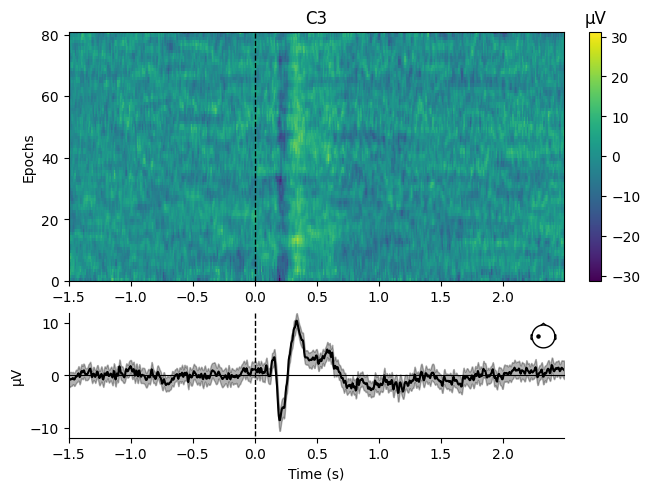

[<Figure size 640x480 with 4 Axes>]

In [41]:
# Specify the event or condition you're interested in
event_id = 'S 104'  # Replace with your specific event ID

# Plot ERP image for a specific channel
epochs[event_id].plot_image(picks=['C3'], sigma=1.0, cmap='viridis')


### Step 4: Topographic Maps

Topographic maps show the potential field on the scalp, which can be useful to visualize the distribution of brain activity at specific times.

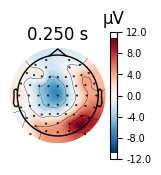

<ipython-input-62-89814d7a7cbc>:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Permuting 49999 times...
Number of significant sensors : 36
Sensors names : ['F7', 'F3', 'F4', 'F8', 'FC1', 'FC6', 'Cz', 'C4', 'T8', 'FCz', 'CP6', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'PO10', 'F5', 'F1', 'F6', 'FT7', 'FC4', 'FT8', 'C1', 'C6', 'CP4', 'TP8', 'P5', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']


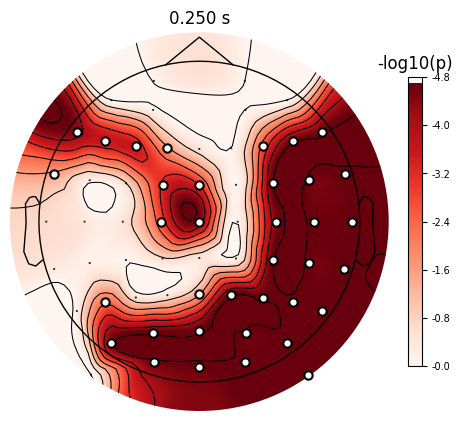

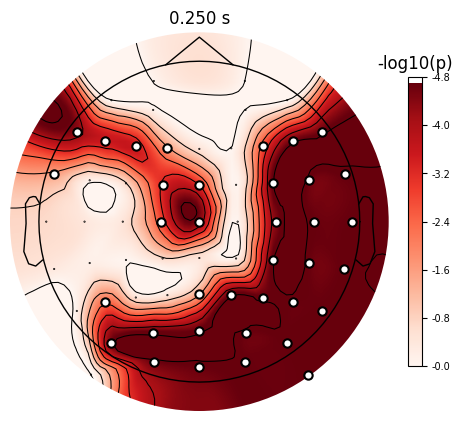

In [62]:
# Time points in seconds (e.g., 250 ms post-stimulus)
times = [0.25]
epochs[event_id].average().plot_topomap(times=times, ch_type='eeg')

# pick EEG Channels
picks = mne.pick_types(
    epochs.info, meg=False, eeg=True, stim=False, eog=True, exclude="bads"
)
data = epochs.get_data()
times = epochs.times

temporal_mask = np.logical_and(0.2 <= times, times <= 0.3)
data = np.mean(data[:, :, temporal_mask], axis=2)

n_permutations = 50000
T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=None)

significant_sensors = picks[p_values <= 0.05]
significant_sensors_names = [epochs.ch_names[k] for k in significant_sensors]

print("Number of significant sensors : %d" % len(significant_sensors))
print("Sensors names : %s" % significant_sensors_names)

evoked = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis], epochs.info, tmin=0.25)

# Extract mask and indices of active sensors in the layout
mask = p_values[:, np.newaxis] <= 0.05

evoked.plot_topomap(
    ch_type="eeg",
    times=[0.25],
    scalings=1,
    time_format=None,
    cmap="Reds",
    vlim=(0.0, np.max),
    units="-log10(p)",
    cbar_fmt="-%0.1f",
    mask=mask,
    size=3,
    show_names=lambda x: x[4:] + " " * 20,
    time_unit="s",
)

### Step 5: Time-Frequency Representation

Time-frequency plots can show how the frequency content of the signal changes over time, which is useful for analyzing oscillatory activity.

Applying baseline correction (mode: logratio)


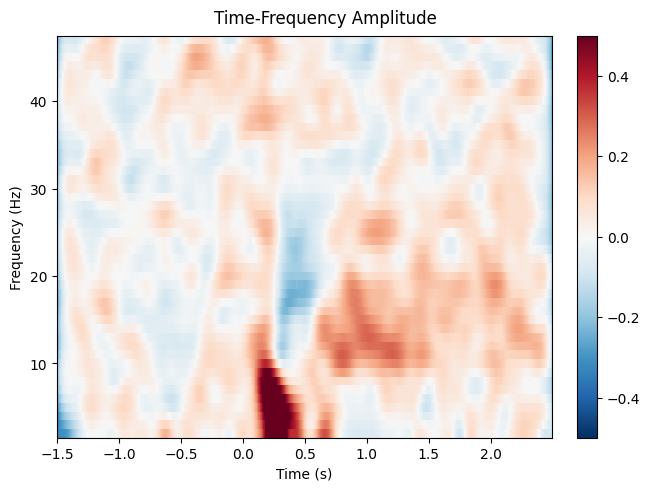

No baseline correction applied


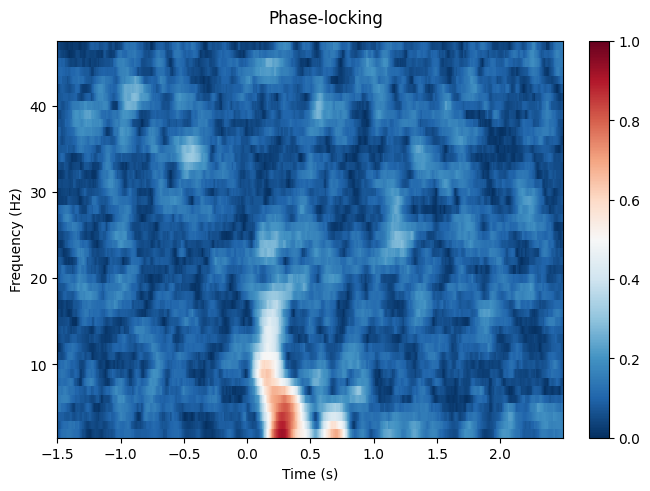

[<Figure size 640x480 with 2 Axes>]

In [47]:
from mne.time_frequency import tfr_morlet
import numpy as np

# Choose channels and frequencies
channels = ['C4']
freqs = np.arange(2, 48)  # 2 to 48 Hz
n_cycles = freqs / 2.  # Different number of cycle per frequency

power, itc = tfr_morlet(epochs[event_id], freqs=freqs, n_cycles=n_cycles, return_itc=True, picks=channels)

# Plotting the time-frequency power
power.plot(baseline=(-1.5, -0.5), mode='logratio', title='Time-Frequency Amplitude', vmin=-0.5, vmax=0.5)

# Plotting the phase-locking value (ITC) with the color scale from 0 to 1
itc.plot(title='Phase-locking', vmin=0, vmax=1)

